In [21]:
# import common packages
import numpy as np

from qiskit import Aer

import matplotlib.pyplot as plt

# lib from Qiskit Aqua
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.components.optimizers import COBYLA

# lib from Qiskit Aqua Chemistry*
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

In [30]:
def get_qubit_op(dist):
    
    angle = 104.45*np.pi/180;
    x = np.cos(angle) * dist;
    y = np.sin(angle) * dist;
    driver = PySCFDriver(atom='H .0 .0 .0; O .0 .0 {}; H {} {} .0'.format(dist, x, y), unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [31]:
backend = Aer.get_backend("statevector_simulator")
distances = np.arange(0.6, 2.0, 0.1)
exact_energies = []
vqe_energies = []
#optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift, = get_qubit_op(dist)
    exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
    ret = exact_eigensolver.run()
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    #vqe = VQE(qubitOp, var_form, optimizer)
    vqe = VQE(qubitOp, var_form)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    exact_result=ret.eigenvalue.real + shift
    exact_energies.append(exact_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:",ret.eigenvalue.real + shift )
    
print("All energies have been calculated")

Interatomic Distance: 0.6 VQE Result: -72.9849374498988 Exact Energy: -72.98493753505154
Interatomic Distance: 0.7 VQE Result: -73.625877750567 Exact Energy: -73.625877770992
Interatomic Distance: 0.8 VQE Result: -74.01491228987054 Exact Energy: -74.01491231691537
Interatomic Distance: 0.9 VQE Result: -74.25362303231223 Exact Energy: -74.2536231112386
Interatomic Distance: 1.0 VQE Result: -74.30853574251216 Exact Energy: -74.30853610906979
Interatomic Distance: 1.1 VQE Result: -74.39751209596973 Exact Energy: -74.39751237412291
Interatomic Distance: 1.2 VQE Result: -74.43985880046905 Exact Energy: -74.43985883295119
Interatomic Distance: 1.3 VQE Result: -74.44663496781274 Exact Energy: -74.44663502333044
Interatomic Distance: 1.4 VQE Result: -74.42477816901705 Exact Energy: -74.4247783090918
Interatomic Distance: 1.5 VQE Result: -74.38731980603593 Exact Energy: -74.3873201022516
Interatomic Distance: 1.6 VQE Result: -74.34834685289667 Exact Energy: -74.3483471844144
Interatomic Distanc

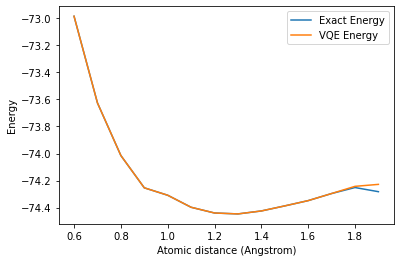

In [32]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()